# This notebook shows how to use the seq2seq model from tensorflow to build a text simplifcation system. The training dataset is the original parallel Wikipedia sentence pairs (PWKP_108016)

In [2]:
import os.path
import os
import tensorflow as tf
import keras
import nltk
from nltk import word_tokenize
from nltk.tokenize.moses import MosesTokenizer
from nltk.tokenize.moses import MosesDetokenizer
import pandas as pd
import numpy as np
import re
import codecs
import sys
import operator
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, './subword_nmt')
from subword_nmt import learn_bpe
from subword_nmt import apply_bpe
sys.path.insert(0, './nmt/nmt')

# sys.path.insert(0, '/Users/tengi/insight-project/lib/pwkp_dataset_parser')
# from pwkp_parser import parse_pwkp_file
# download the princeton wordnet, once run it once
# nltk.download('wordnet') 
from nltk.stem.wordnet import WordNetLemmatizer
%matplotlib inline
#nltk.download('all')

In [2]:
# download the PWKP dataset to local data directory and unzip it
!wget -nv https://www.ukp.tu-darmstadt.de/fileadmin/user_upload/Group_UKP/files/PWKP_108016.tar.gz -P ./data/PWKP
!tar -xzf ./data/PWKP/PWKP_108016.tar.gz -C ./data/PWKP

--2018-01-24 01:43:17--  https://www.ukp.tu-darmstadt.de/fileadmin/user_upload/Group_UKP/files/PWKP_108016.tar.gz
Resolving www.ukp.tu-darmstadt.de (www.ukp.tu-darmstadt.de)... 130.83.162.6
Connecting to www.ukp.tu-darmstadt.de (www.ukp.tu-darmstadt.de)|130.83.162.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8221550 (7.8M) [application/x-gzip]
Saving to: ‘./data/PWKP/PWKP_108016.tar.gz’

PWKP_108016.tar.gz  100%[===================>]   7.84M   709KB/s    in 14s     

2018-01-24 01:43:32 (576 KB/s) - ‘./data/PWKP/PWKP_108016.tar.gz’ saved [8221550/8221550]



In [3]:
pwkp_source_file = 'data/PWKP/PWKP_108016'
translations = []

# generate complex-simple paris in translations
def retrieve_complex_simplex_translations(src_file):
    total_simple_sentences = 0;
    with open(pwkp_source_file) as pwkp_file:
            translation_beginning = True
            translation = None
            for line in pwkp_file:
                if translation_beginning:
                    translation = (line.strip(), "")
                    translation_beginning = False
                else:
                    if line == "\n":
                        translation_beginning = True
                        translations.append(translation)
                    else:
                        total_simple_sentences += 1;
                        source, target = translation
                        translation =\
                            (source, target + line.strip() + " ")
    return (translations, total_simple_sentences);

In [4]:
# get complex-simple pairs
translations, total_simple_sentences = retrieve_complex_simplex_translations(pwkp_source_file)
total_complex_sentences = len(translations)

In [5]:
# random shuffle the dataset for train/dev/test split
np.random.shuffle(translations)

complex_sentences = [pair[0] for pair in translations]
simple_sentences = [pair[1] for pair in translations]

#tokenize the text by Moses Tokenizer
tokenizer = MosesTokenizer()
complex_tok_str = [tokenizer.tokenize(sent, return_str = True) for sent in complex_sentences]
simple_tok_str = [tokenizer.tokenize(sent, return_str = True) for sent in simple_sentences] 

complex_tok_words = [word for sent in complex_tok_str for word in sent.split()]
simple_tok_words = [word for sent in simple_tok_str for word in sent.split()]

In [6]:
complex_fdist = nltk.FreqDist(complex_tok_words)
simple_fdist = nltk.FreqDist(simple_tok_words)

complex_chars = sum([len(word) for word in complex_fdist.keys()])
simple_chars = sum([len(word) for word in simple_fdist.keys()])

df = pd.DataFrame({'name': ['complex', 'simple'],
                   '#tokens/sentence': [complex_fdist.N()/total_complex_sentences, simple_fdist.N()/total_simple_sentences],
                   '#chars/tokens': [complex_chars/complex_fdist.B(), simple_chars/simple_fdist.B()],
                   '#unique tokens': [complex_fdist.B(), simple_fdist.B()]})
df.set_index('name')

,#chars/tokens,#tokens/sentence,#unique tokens
name,,,
complex,7.844607,24.516238,112901
simple,7.562868,18.945573,93521


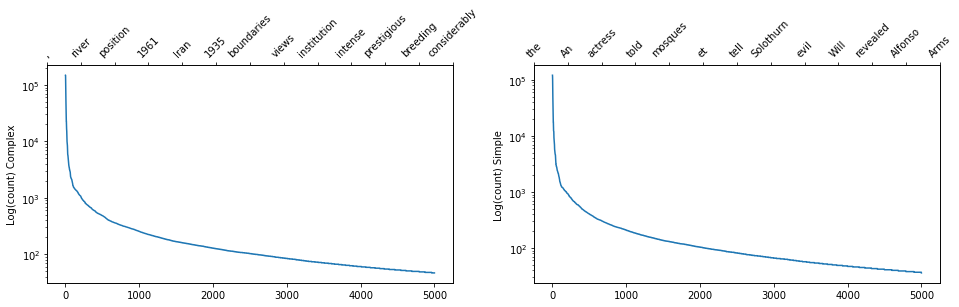

In [7]:
plt.figure(figsize=(16, 4))
N = 5000
subIndex = range(0, N, 400)
complex_freq_list = complex_fdist.most_common()
simple_freq_list = simple_fdist.most_common()

complex_words = [complex_freq_list[i][0] for i in subIndex]
simple_words = [simple_freq_list[i][0] for i in subIndex]

axe = plt.subplot(1,2,1)
h1 = plt.plot(range(N), np.array([pair[1] for pair in complex_freq_list[:5000]]))
plt.ylabel('Log(count) Complex')
axe1 = axe.twiny()
plt.xticks(subIndex, np.array(complex_words), rotation = 45)
plt.yscale('log')
axe = plt.subplot(1,2,2)
h2 = plt.plot(range(N), np.array([pair[1] for pair in simple_freq_list[:5000]]))
plt.ylabel('Log(count) Simple')
axe1 = axe.twiny()
plt.xticks(subIndex, np.array(simple_words), rotation = 45)
plt.yscale('log')

In [8]:
corpus_file = 'data/PWKP/PWKP_108016.tok'

complex_sentences_file = 'data/PWKP/complex.tok'
simple_sentences_file = 'data/PWKP/simple.tok'

complex_train_file = 'data/PWKP/train.tok.complex'
simple_train_file = 'data/PWKP/train.tok.simple'

complex_val_file = 'data/PWKP/val.tok.complex'
simple_val_file = 'data/PWKP/val.tok.simple'

complex_test_file = 'data/PWKP/test.tok.complex'
simple_test_file = 'data/PWKP/test.tok.simple'

val_size = 300
test_size = 300

with open(corpus_file, 'w') as f:
    for i in range(len(complex_tok_str)):
        f.write(complex_tok_str[i] + '\n')
        f.write(simple_tok_str[i] + '\n\n')
        
        
with open(complex_sentences_file, 'w') as f:
    for sent in complex_tok_str:
        f.write(sent + '\n')
        
with open(simple_sentences_file, 'w') as f:
    for sent in simple_tok_str:
        f.write(sent + '\n')
 
with open(complex_train_file, 'w') as f:
    for sent in complex_tok_str[:-(val_size+test_size)]:
        f.write(sent + '\n')
        
with open(simple_train_file, 'w') as f:
    for sent in simple_tok_str[:-(val_size+test_size)]:
        f.write(sent + '\n')
        
with open(complex_val_file, 'w') as f:
    for sent in complex_tok_str[-(val_size+test_size):-test_size]:
        f.write(sent + '\n')
        
with open(simple_val_file, 'w') as f:
    for sent in simple_tok_str[-(val_size+test_size):-test_size]:
        f.write(sent + '\n')
        
with open(complex_test_file, 'w') as f:
    for sent in complex_tok_str[-test_size:]:
        f.write(sent + '\n')
        
with open(simple_test_file, 'w') as f:
    for sent in simple_tok_str[-test_size:]:
        f.write(sent + '\n')
        
    

In [9]:
# Learn a byte-pair-encoding (bpe) vocabulary using 10,000 merge operations
!./subword_nmt/learn_bpe.py -s 10000 < data/PWKP/PWKP_108016.tok > data/PWKP/codes.bpe

# Apply the vocabulary to the training file
!./subword_nmt/apply_bpe.py -c data/PWKP/codes.bpe < data/PWKP/PWKP_108016.tok > data/PWKP/PWKP_108016.tok.bpe
!./subword_nmt/apply_bpe.py -c data/PWKP/codes.bpe < data/PWKP/complex.tok > data/PWKP/complex.tok.bpe
!./subword_nmt/apply_bpe.py -c data/PWKP/codes.bpe < data/PWKP/simple.tok > data/PWKP/simple.tok.bpe

!./subword_nmt/apply_bpe.py -c data/PWKP/codes.bpe < data/PWKP/train.tok.complex > data/PWKP/train.tok.bpe.complex

!./subword_nmt/apply_bpe.py -c data/PWKP/codes.bpe < data/PWKP/train.tok.simple > data/PWKP/train.tok.bpe.simple

!./subword_nmt/apply_bpe.py -c data/PWKP/codes.bpe < data/PWKP/val.tok.complex > data/PWKP/val.tok.bpe.complex

!./subword_nmt/apply_bpe.py -c data/PWKP/codes.bpe < data/PWKP/val.tok.simple > data/PWKP/val.tok.bpe.simple

!./subword_nmt/apply_bpe.py -c data/PWKP/codes.bpe < data/PWKP/test.tok.complex > data/PWKP/test.tok.bpe.complex

!./subword_nmt/apply_bpe.py -c data/PWKP/codes.bpe < data/PWKP/test.tok.simple > data/PWKP/test.tok.bpe.simple

!cat data/PWKP/PWKP_108016.tok.bpe | ./subword_nmt/get_vocab.py > data/PWKP/PWKP_108016.vocab.tok.bpe
!cat data/PWKP/complex.tok.bpe | ./subword_nmt/get_vocab.py > data/PWKP/vocab.tok.bpe.complex
!cat data/PWKP/simple.tok.bpe | ./subword_nmt/get_vocab.py > data/PWKP/vocab.tok.bpe.simple

In [11]:
detokenizer = MosesDetokenizer()
detokenizer.detokenize("a b , cd .", return_str = True)

'a b, c d.'

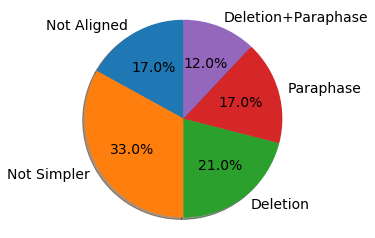

In [12]:
# Numbers borrowed from "Problems in Current Text Simplification Research: New Data Can Help."
# Problems in PWKP dataset
labels = 'Not Aligned', 'Not Simpler', 'Deletion', 'Paraphase', 'Deletion+Paraphase'
sizes = [17, 33, 21, 17, 12]

fig1, ax1 = plt.subplots()
patches, texts, autotexts = ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
for text in texts:
    text.set_fontsize(14)
for autotext in autotexts:
    autotext.set_fontsize(14)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [13]:
fdist = nltk.FreqDist(complex_tok_words+simple_tok_words)
print("Number of tokens before subword segmentation: {}".format(fdist.B()))

text_file = open(r'data/PWKP/PWKP_108016.tok.bpe',"r")
p = text_file.read()
words = word_tokenize(p)
fdist = nltk.FreqDist(words)
print("Number of tokens after subword segmentation: {}".format(fdist.B()))


Number of tokens before subword segmentation: 121793
Number of tokens after subword segmentation: 9239
